<a href="https://colab.research.google.com/github/TruscaPetre/AAIT-Nosy-Missing-Labels/blob/main/tutorial%20colab%20missing%20labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missing Labels problem

## Theory about missing labels


- The classification problem can be tackled using semi-supervised learning methods. There are 3 propular approaches to address semi-supervised learning problems:
  - self training
  - co-training
  - graph-based models
- self training 
  - What is the process?
    - First train on labeled data
    - Make predictions on the untrained data
    - From those predictions, only extract those with high confidence and move them to the training data
    - Repeat the process until convergence or no high-confidence exmples left in the unlabeled set.
  - Disadvantage is that you can still generate incorrect predictions and the mistakes can be amplified in the subsequent trainings of the model.
- co-training
  - requires two feature representations associated with the dataset which serve as two different views of the data
  - The representations are dissimilar and conditionally independet, but they can provide complementary information about the data. 
  - We cannot do this for image classification because we have only visual representations of the data.
- graph-based models
  - labeled and unlabeled samples are represented as different nodes in a graph
  - the edges in this graph denote the similarity between nodes.
  - The assumption in this approach is that nodes with strong edges are likely to share the same label.
  - The algorithm to compute the labels is:
    - The unlabeled nodes can be labeled using random-walk over the graph. Based on the strength of the edges.
    - The walk ends when a labeled node is reached 
    - A probability that the random walker started at a particular unlabeled node given that it ended at a specific labeled node is computed. i.e. 2 poitns are similar if they have indistinguishabel starting points.


Reference: 
- https://www.kdnuggets.com/2019/11/tips-class-imbalance-missing-labels.html

## Imports, libraries, datasets, preparations

In [1]:
import urllib
import shutil
import os
import time
import copy
import json

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader
from torchvision import transforms, datasets 

from sklearn.metrics import classification_report

import itertools



In [2]:
task1_id = "1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd"

In [3]:
# replace here your ide &id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd"
# replace here your id 'https://docs.google.com/uc?export=download&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd'
# replace here your target name -O task1.tar.gz &&
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd" -O task1.tar.gz && rm -rf /tmp/cookies.txt


--2023-01-10 17:36:24--  https://docs.google.com/uc?export=download&confirm=t&id=1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd
Resolving docs.google.com (docs.google.com)... 172.217.203.138, 172.217.203.102, 172.217.203.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rt8q1ditccjjnpo83bpmo4dbcid6ckt8/1673372175000/08997952672865575084/*/1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd?e=download&uuid=394fb3f7-3475-4426-8dec-fe72e4ec0e86 [following]
--2023-01-10 17:36:24--  https://doc-0g-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rt8q1ditccjjnpo83bpmo4dbcid6ckt8/1673372175000/08997952672865575084/*/1dO1vqCoJm2xwrnr171A6_eW7ikd-alrd?e=download&uuid=394fb3f7-3475-4426-8dec-fe72e4ec0e86
Resolving doc-0g-8k-docs.googleusercontent.com (doc-0g-8k-docs.googleusercontent.com)... 172.217.204.

In [4]:
%%capture
!mkdir data
!mv task1.tar.gz ./data
!tar -xzvf "/content/data/task1.tar.gz" -C "/content/data/"     #[run this cell to extract tar.gz files]
# this may take 12 seconds

In [9]:
# !rm -r /content/data/task1

### Set up logging


This experiment will take long, because there are many trianig periods involved and many changes going on in the data. There are some things that could be helpful to track along the way. So we set up a logger that will do this.

We are going to track: 
- all the hyperparameters for training.
- all the seeds for RNG
- the images that have been labeled at each iteration. 
- performance metrics ( we should see them increase through each iteration )

We are going to use a dictionary that will save all the data from each iteration of the experiment. Than save that dictionary into a json file for each iteration. 

There is a json file in the github repository with all the parameters for the first experiment.

Some comments about setting those parameters:
- The number of epochs is only 10 because according to the training only on the dataset with labeled data, this is the point where the validation set is reaching a saturation. In order to achieve the results faster from self-training, we should keep this number as small as possible.

In [5]:
experiment_info = {
    "iteration": 1,
    "image_processing":{
        "resize":224,
        "mean":[0.485, 0.456, 0.406],
        "std":[0.229, 0.224, 0.225],
    },
    "hyperparameters_data": {
        "batch_size":32,
        "shuffle_dataloader":True,
        "num_workers":4
    },
    "random_seeds":{
        "torch_seed":42,
        "numpy_seed":42,
        "cuda_seed":42,

    },
    "hyperparameters_training":{
        "learning_rate": 0.0001,
        "scheduler_step_size":7,
        "scheduler_gamma":0.1,
        "num_epochs":10, 
    },
    "total_unlabeled":26445,
}

In [6]:
# Save the dictionary to a file
with open("experiment_info.json", "w") as f:
    json.dump(experiment_info, f)

In [7]:
np.random.seed(experiment_info["random_seeds"]["numpy_seed"])
torch.manual_seed(experiment_info["random_seeds"]["torch_seed"])
torch.cuda.manual_seed_all(experiment_info["random_seeds"]["cuda_seed"])

In [8]:
# Load the experiment information from the JSON file
with open('experiment_info.json', 'r') as f:
    loaded_experiment_info = json.load(f)

display(loaded_experiment_info)

{'iteration': 1,
 'image_processing': {'resize': 224,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225]},
 'hyperparameters_data': {'batch_size': 32,
  'shuffle_dataloader': True,
  'num_workers': 4},
 'random_seeds': {'torch_seed': 42, 'numpy_seed': 42, 'cuda_seed': 42},
 'hyperparameters_training': {'learning_rate': 0.0001,
  'scheduler_step_size': 7,
  'scheduler_gamma': 0.1,
  'num_epochs': 10},
 'total_unlabeled': 26445}

### Mount drive

Each iteration of self-training takes about 1 hour on a GPU. So you might want to save and restart the training a few times. In order to restart the model where we where left of, we are connecting google drive and saving the model there.

In [9]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [10]:
with open('/gdrive/MyDrive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/MyDrive/foo.txt'

Hello Google Drive!

In [11]:
!rm '/gdrive/MyDrive/foo.txt'

### Prepare datasets

In [12]:
dir_data = 'data/task1/train_data/'
# Read the annotations file into a DataFrame
df = pd.read_csv(f'{dir_data}annotations.csv')

In [13]:
# Organize data for pytorch training ( only once )
# Define the base directory
base_dir = 'data/task1/labeled'

# Iterate over the rows in the DataFrame
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Extract the path and class from the row
    path = row['sample']
    label = row['label']
    
    # Create the directory for the class
    class_dir = f'{base_dir}/{label}'
    os.makedirs(class_dir, exist_ok=True)
    
    # Copy the file to the class directory
    shutil.copy(f"data/{path}", class_dir) 

100%|██████████| 23555/23555 [00:05<00:00, 4083.94it/s]


In [14]:
preprocess = transforms.Compose([
    transforms.Resize(experiment_info["image_processing"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=experiment_info["image_processing"]["mean"],
                         std=experiment_info["image_processing"]["std"]),
    ])

data_dir = 'data/task1/labeled'
image_dataset = datasets.ImageFolder(data_dir, preprocess) 
dataloader  = DataLoader(
    image_dataset, 
    batch_size = experiment_info["hyperparameters_data"]["batch_size"],
    shuffle = experiment_info["hyperparameters_data"]["shuffle_dataloader"], 
    num_workers = experiment_info["hyperparameters_data"]["num_workers"]
    )

class_names = image_dataset.classes
dataset_size = len(image_dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Self Training Solution

## Training on labeled data

### Download model

In [15]:
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# change the Linear output to fit our dataset

# the model has initially 1000 outputs
# print(model.classifier)
# > Sequential(
#   (0): Dropout(p=0.2)
#   (1): Linear(in_features=1280, out_features=1000, bias=True)
# )

model.classifier[1] = nn.Linear(1280, 100)
print(model.classifier)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


### Start training

In [ ]:
def train_loop(model, scheduler, optimizer, criterion, dataset_size, dataloader):
                     
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
    
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    return model, epoch_loss, epoch_acc

def train_model(model, *args, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  # Set model to training mode
        model, epoch_loss, epoch_acc = train_loop(model, *args)
        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Setting hyperparameters

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(
    model.parameters(),
    lr=experiment_info["hyperparameters_training"]["learning_rate"],
    )

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size=experiment_info["hyperparameters_training"]["scheduler_step_size"], 
    gamma=experiment_info["hyperparameters_training"]["scheduler_gamma"],
    )

In [ ]:
model = train_model(model, 
                    exp_lr_scheduler, 
                    optimizer, 
                    criterion,  
                    dataset_size, 
                    dataloader, 
                    num_epochs=experiment_info["hyperparameters_training"]["num_epochs"])

Epoch 0/9
----------


100%|██████████| 798/798 [01:46<00:00,  7.47it/s]


Loss: 2.6056 Acc: 0.4191

Epoch 1/9
----------


100%|██████████| 798/798 [01:44<00:00,  7.62it/s]


Loss: 1.4541 Acc: 0.6384

Epoch 2/9
----------


100%|██████████| 798/798 [01:44<00:00,  7.62it/s]


Loss: 1.0391 Acc: 0.7274

Epoch 3/9
----------


  8%|▊         | 62/798 [00:08<01:44,  7.01it/s]


KeyboardInterrupt: ignored

In [ ]:
# Save the model
torch.save(model.state_dict(), '/gdrive/MyDrive/checkpoints/missing_labels/model_it_0.pt')

## Predict new set of labels

In [15]:
# Set the source and destination directories
source_dir = 'data/task1/train_data/images/unlabeled'
destination_dir = 'data/task1/train_data/images/unlabeled/0'
os.makedirs(destination_dir, exist_ok=True)

In [16]:
# Iterate over all the files in the source directory
for file in tqdm(os.listdir(source_dir)):
    if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
        # Construct the source and destination paths
        src_path = os.path.join(source_dir, file)
        dst_path = os.path.join(destination_dir, file)
        # Move the file
        shutil.move(src_path, dst_path) 

100%|██████████| 26446/26446 [00:00<00:00, 30292.54it/s]


In [17]:
# sanity check to see that all images have been moved to unlabeled/0 dir
len(os.listdir(destination_dir)) # 26445

26445

In [23]:
# Create a new dataloader with unlabeled data.
# Dataset folder is a subclass of ImageFolder 
# Which will allow us to return also the path of the image
# because we need it to know which images should be moved 

from torchvision.datasets import DatasetFolder

data_dir = 'data/task1/train_data/images/unlabeled'
image_dataset_unlabeled = datasets.ImageFolder(root=data_dir, transform=preprocess)

dataloader_unlabeled  = torch.utils.data.DataLoader(
    image_dataset_unlabeled, 
    batch_size = 1, 
    )

dataset_size = len(image_dataset_unlabeled)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
predicted_labels = {
    "path":[],
    "confidence":[],
    "label":[]
}

# Each epoch has a training and validation phase 
model.eval()   # Set model to evaluate mode 

# Iterate over data.
img_path_generator = ((image, path) for (path,_) , (image, _) in zip(image_dataset_unlabeled.samples, dataloader_unlabeled))

for inputs, path in tqdm(img_path_generator, total=dataset_size):
    inputs = inputs.to(device)

    # forward
    with torch.set_grad_enabled(False): # we don't want to train
        outputs = model(inputs)
        confidence, preds = torch.max(outputs, 1) 
    predicted_labels["path"].append(path) 
    predicted_labels["confidence"].append(confidence.item())
    predicted_labels["label"].append(preds.item())


    

100%|██████████| 26445/26445 [03:43<00:00, 118.07it/s]


### Visualize the predictions

Text(0.5, 1.0, 'Distribution of Confidence Scores')

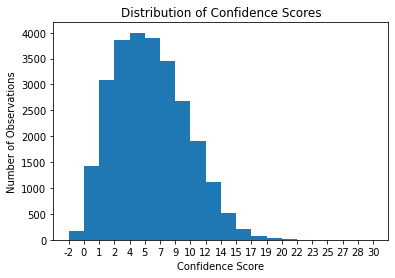

In [ ]:
# Plot a distribution of the convidence scores. To find a threshold
counts, bins, patches = plt.hist(predicted_labels["confidence"], bins = 20)

# Set x-axis label
plt.xlabel('Confidence Score')
plt.xticks(bins, bins.astype(int))
# Set y-axis label
plt.ylabel('Number of Observations')

# Set plot title
plt.title('Distribution of Confidence Scores')

In [ ]:
print(bins)

[-2.2711072  -0.63155334  1.00800052  2.64755437  4.28710823  5.92666209
  7.56621594  9.2057698  10.84532366 12.48487751 14.12443137 15.76398523
 17.40353909 19.04309294 20.6826468  22.32220066 23.96175451 25.60130837
 27.24086223 28.88041608 30.51996994]


In [ ]:
# Select the top X bins but not more than 10% of the unlabeled dataset
# to move into the labeled dataset
top10 = experiment_info["total_unlabeled"]*0.1
if sum(counts)>top10:
    for x in range(20):
        top10-=counts[-x-1]
        if top10 < 0:
            break
    n_keep = int(sum(counts[-x:]))
else:
    n_keep = int(sum(counts))
print(n_keep)

1962


In [ ]:
# Sort the confidence scores in descending order
sorted_confidences = np.sort(predicted_labels["confidence"])[::-1]

# Keep the first n_keep scores
top_confidences = sorted_confidences[:n_keep]

# Find the indices of the top confidences in the original list of confidences
top_confidence_indices = [i for i, c in enumerate(predicted_labels["confidence"]) if c in top_confidences]

# Use the indices to select the corresponding paths and labels
top_confidences = [predicted_labels["confidence"][i] for i in top_confidence_indices]
top_paths = [predicted_labels["path"][i] for i in top_confidence_indices]
top_labels = [predicted_labels["label"][i] for i in top_confidence_indices]

In [ ]:
iteration_predictions = {
    "path":top_paths,
    "confidence":top_confidences,
    "label":top_labels
}

In [ ]:
# Load the experiment information from the JSON file
num_iteration = 0
# Save the experiment information to a JSON file
with open(f'iteration_{num_iteration}_images.json', 'w') as f:
    json.dump(iteration_predictions, f)

In [ ]:
# Load the experiment information from the JSON file
with open(f'iteration_{num_iteration}_images.json', 'r') as f:
    iteration_predictions = json.load(f)

df_labeled = pd.DataFrame(iteration_predictions)


In [ ]:
# Move the images above the trashold in the dataset
# Iterate through the selected rows and move the images
for index, row in tqdm(df_labeled.iterrows(),total=n_keep):
    parts = row['path'].split(".")
    parts[0]+=f"_it_{num_iteration}"
    new_name = ".".join(parts).split('/')[-1]
    shutil.move(row['path'], f"data/task1/labeled/{row['label']}/{new_name}")

100%|██████████| 1962/1962 [00:01<00:00, 1453.06it/s]


In [ ]:
# sanity check to see that all images have been moved to unlabeled/0 dir
 # 
assert experiment_info["total_unlabeled"] - n_keep == len(os.listdir(destination_dir)) # 26445 - 1962 = 24483

## Repeat the following iterations of self-training

In [18]:
def create_dataset():
    data_dir = 'data/task1/labeled'
    preprocess = transforms.Compose([
    transforms.Resize(experiment_info["image_processing"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=experiment_info["image_processing"]["mean"],
                         std=experiment_info["image_processing"]["std"]),
    ])
    image_dataset = datasets.ImageFolder(data_dir, preprocess) 
    dataloader  = DataLoader(
        image_dataset, 
        batch_size = experiment_info["hyperparameters_data"]["batch_size"],
        shuffle = experiment_info["hyperparameters_data"]["shuffle_dataloader"], 
        num_workers = experiment_info["hyperparameters_data"]["num_workers"]
        )

    class_names = image_dataset.classes
    dataset_size = len(image_dataset)
    return class_names, dataset_size, dataloader
 

def get_hyper_parameters():
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(
        model.parameters(),
        lr=experiment_info["hyperparameters_training"]["learning_rate"],
        )

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(
        optimizer, 
        step_size=experiment_info["hyperparameters_training"]["scheduler_step_size"], 
        gamma=experiment_info["hyperparameters_training"]["scheduler_gamma"],
        )
    return criterion, optimizer, exp_lr_scheduler

def get_unlabled_dataset():
    data_dir = 'data/task1/train_data/images/unlabeled'
    image_dataset_unlabeled = datasets.ImageFolder(root=data_dir, transform=preprocess)
    dataloader_unlabeled  = torch.utils.data.DataLoader(
        image_dataset_unlabeled, 
        batch_size = 1, 
        )
    dataset_size_unlabeled = len(image_dataset_unlabeled)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return dataset_size_unlabeled, dataloader_unlabeled, image_dataset_unlabeled

def predict_new_labels(model):
    dataset_size_unlabeled, dataloader_unlabeled, image_dataset_unlabeled = get_unlabled_dataset()
    predicted_labels = {
        "path":[],
        "confidence":[],
        "label":[]
    }

    # Each epoch has a training and validation phase 
    model.eval()   # Set model to evaluate mode 

    # Iterate over data.
    img_path_generator = ((image, path) for (path,_) , (image, _) in zip(image_dataset_unlabeled.samples, dataloader_unlabeled))

    for inputs, path in tqdm(img_path_generator, total=dataset_size_unlabeled):
        inputs = inputs.to(device)

        # forward
        with torch.set_grad_enabled(False): # we don't want to train
            outputs = model(inputs)
            confidence, preds = torch.max(outputs, 1) 
        predicted_labels["path"].append(path) 
        predicted_labels["confidence"].append(confidence.item())
        predicted_labels["label"].append(preds.item())
        
    return predicted_labels

def plot_distribution():
    # Plot a distribution of the convidence scores. To find a threshold
    counts, bins, patches = plt.hist(predicted_labels["confidence"], bins = 20)

    # Set x-axis label
    plt.xlabel('Confidence Score')
    plt.xticks(bins, bins.astype(int))
    # Set y-axis label
    plt.ylabel('Number of Observations')

    # Set plot title
    plt.title('Distribution of Confidence Scores')
    return counts, bins, patches

def compute_keep(counts):
    top10 = experiment_info["total_unlabeled"]*0.1
    if sum(counts)>top10:
        for x in range(20):
            top10-=counts[-x-1]
            if top10 < 0:
                break
        n_keep = int(sum(counts[-x:]))
    else:
        n_keep = int(sum(counts))
    return n_keep

def extract_kept_images(predicted_labels, n_keep):
    # Sort the confidence scores in descending order
    sorted_confidences = np.sort(predicted_labels["confidence"])[::-1]

    # Keep the first n_keep scores
    top_confidences = sorted_confidences[:n_keep]

    # Find the indices of the top confidences in the original list of confidences
    top_confidence_indices = [i for i, c in enumerate(predicted_labels["confidence"]) if c in top_confidences]

    # Use the indices to select the corresponding paths and labels
    top_confidences = [predicted_labels["confidence"][i] for i in top_confidence_indices]
    top_paths = [predicted_labels["path"][i] for i in top_confidence_indices]
    top_labels = [predicted_labels["label"][i] for i in top_confidence_indices]
    iteration_predictions = {
        "path":top_paths,
        "confidence":top_confidences,
        "label":top_labels
    }
    return iteration_predictions

def save_images_predicted_json(iteration_predictions, num_iteration):
    # Save the experiment information to a JSON file
    with open(f'/gdrive/MyDrive/checkpoints/missing_labels/iteration_{num_iteration}_images.json', 'w') as f:
        json.dump(iteration_predictions, f)

def move_images_predicted(num_iteration):
    # Load the experiment information from the JSON file
    with open(f'/gdrive/MyDrive/checkpoints/missing_labels/iteration_{num_iteration}_images.json', 'r') as f:
        iteration_predictions = json.load(f)

    df_labeled = pd.DataFrame(iteration_predictions)
    # Move the images above the trashold in the dataset
    # Iterate through the selected rows and move the images
    for index, row in tqdm(df_labeled.iterrows(),total=n_keep):
        parts = row['path'].split(".")
        parts[0]+=f"_it_{num_iteration}"
        new_name = ".".join(parts).split('/')[-1]
        shutil.move(row['path'], f"data/task1/labeled/{row['label']}/{new_name}")



In [ ]:
def train_new_model(num_epochs=experiment_info["hyperparameters_training"]["num_epochs"]):
    # Download a pytorch MobileNet pretrained model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    # change the Linear output to fit our dataset

    # the model has initially 1000 outputs
    # print(model.classifier)
    # > Sequential(
    #   (0): Dropout(p=0.2)
    #   (1): Linear(in_features=1280, out_features=1000, bias=True)
    # )

    model.classifier[1] = nn.Linear(1280, 100) 

    preprocess = transforms.Compose([
        transforms.Resize(experiment_info["image_processing"]["resize"]),
        transforms.ToTensor(),
        transforms.Normalize(mean=experiment_info["image_processing"]["mean"],
                            std=experiment_info["image_processing"]["std"]),
        ])

    data_dir = 'data/task1/labeled'
    image_dataset = datasets.ImageFolder(data_dir, preprocess) 
    dataloader  = DataLoader(
        image_dataset, 
        batch_size = experiment_info["hyperparameters_data"]["batch_size"],
        shuffle = experiment_info["hyperparameters_data"]["shuffle_dataloader"], 
        num_workers = experiment_info["hyperparameters_data"]["num_workers"]
        )

    class_names = image_dataset.classes
    dataset_size = len(image_dataset)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Setting hyperparameters

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(
        model.parameters(),
        lr=experiment_info["hyperparameters_training"]["learning_rate"],
        )

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(
        optimizer, 
        step_size=experiment_info["hyperparameters_training"]["scheduler_step_size"], 
        gamma=experiment_info["hyperparameters_training"]["scheduler_gamma"],
        )

    model = train_model(model, 
                        exp_lr_scheduler, 
                        optimizer, 
                        criterion,  
                        dataset_size, 
                        dataloader, 
                        num_epochs=num_epochs)
    return model

def label_and_move_images(model):
    predicted_labels = predict_new_labels(model)
    counts, bins, patches = plot_distribution()
    n_keep = compute_keep(counts)
    iteration_predictions = extract_kept_images(predicted_labels, n_keep)
    save_images_predicted_json(iteration_predictions, num_iteration)
    move_images_predicted(num_iteration)

In [ ]:
num_iteration = 1

In [ ]:
path_m = f'/gdrive/MyDrive/checkpoints/missing_labels/model_it_{num_iteration}.pt'
torch.save(model.state_dict(), path_m)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker

Epoch 0/9
----------


100%|██████████| 880/880 [01:54<00:00,  7.70it/s]


Loss: 2.6766 Acc: 0.3875

Epoch 1/9
----------


100%|██████████| 880/880 [01:54<00:00,  7.68it/s]


Loss: 1.5529 Acc: 0.5828

Epoch 2/9
----------


100%|██████████| 880/880 [01:57<00:00,  7.50it/s]


Loss: 1.1413 Acc: 0.6680

Epoch 3/9
----------


100%|██████████| 880/880 [01:55<00:00,  7.61it/s]


Loss: 0.8654 Acc: 0.7364

Epoch 4/9
----------


100%|██████████| 880/880 [01:55<00:00,  7.63it/s]


Loss: 0.6489 Acc: 0.7946

Epoch 5/9
----------


100%|██████████| 880/880 [01:57<00:00,  7.51it/s]


Loss: 0.4791 Acc: 0.8468

Epoch 6/9
----------


100%|██████████| 880/880 [01:55<00:00,  7.63it/s]


Loss: 0.3545 Acc: 0.8908

Epoch 7/9
----------


100%|██████████| 880/880 [01:57<00:00,  7.52it/s]


Loss: 0.1969 Acc: 0.9528

Epoch 8/9
----------


100%|██████████| 880/880 [01:55<00:00,  7.63it/s]


Loss: 0.1522 Acc: 0.9698

Epoch 9/9
----------


100%|██████████| 880/880 [01:57<00:00,  7.50it/s]


Loss: 0.1335 Acc: 0.9772

Training complete in 19m 20s
Best val Acc: 0.977181


 83%|████████▎ | 2161/2617 [00:00<00:00, 11199.60it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


2  completed
Epoch 0/9
----------


100%|██████████| 947/947 [02:06<00:00,  7.50it/s]


Loss: 2.6762 Acc: 0.3626

Epoch 1/9
----------


100%|██████████| 947/947 [02:04<00:00,  7.61it/s]


Loss: 1.5669 Acc: 0.5460

Epoch 2/9
----------


100%|██████████| 947/947 [02:06<00:00,  7.51it/s]


Loss: 1.1853 Acc: 0.6293

Epoch 3/9
----------


100%|██████████| 947/947 [02:04<00:00,  7.62it/s]


Loss: 0.9233 Acc: 0.6977

Epoch 4/9
----------


100%|██████████| 947/947 [02:06<00:00,  7.51it/s]


Loss: 0.7201 Acc: 0.7580

Epoch 5/9
----------


100%|██████████| 947/947 [02:04<00:00,  7.61it/s]


Loss: 0.5570 Acc: 0.8092

Epoch 6/9
----------


100%|██████████| 947/947 [02:05<00:00,  7.52it/s]


Loss: 0.4369 Acc: 0.8515

Epoch 7/9
----------


100%|██████████| 947/947 [02:04<00:00,  7.62it/s]


Loss: 0.2512 Acc: 0.9330

Epoch 8/9
----------


100%|██████████| 947/947 [02:06<00:00,  7.51it/s]


Loss: 0.2046 Acc: 0.9523

Epoch 9/9
----------


100%|██████████| 947/947 [02:04<00:00,  7.61it/s]


Loss: 0.1784 Acc: 0.9621

Training complete in 20m 53s
Best val Acc: 0.962106


 83%|████████▎ | 2161/2617 [00:00<00:00, 10389.65it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


3  completed
Epoch 0/9
----------


100%|██████████| 1015/1015 [02:13<00:00,  7.61it/s]


Loss: 2.6719 Acc: 0.3456

Epoch 1/9
----------


100%|██████████| 1015/1015 [02:14<00:00,  7.53it/s]


Loss: 1.5832 Acc: 0.5189

Epoch 2/9
----------


100%|██████████| 1015/1015 [02:15<00:00,  7.51it/s]


Loss: 1.2159 Acc: 0.5959

Epoch 3/9
----------


100%|██████████| 1015/1015 [02:13<00:00,  7.61it/s]


Loss: 0.9741 Acc: 0.6591

Epoch 4/9
----------


100%|██████████| 1015/1015 [02:15<00:00,  7.51it/s]


Loss: 0.7754 Acc: 0.7226

Epoch 5/9
----------


100%|██████████| 1015/1015 [02:13<00:00,  7.61it/s]


Loss: 0.6152 Acc: 0.7772

Epoch 6/9
----------


100%|██████████| 1015/1015 [02:15<00:00,  7.51it/s]


Loss: 0.4873 Acc: 0.8257

Epoch 7/9
----------


100%|██████████| 1015/1015 [02:13<00:00,  7.62it/s]


Loss: 0.2888 Acc: 0.9184

Epoch 8/9
----------


100%|██████████| 1015/1015 [02:14<00:00,  7.54it/s]


Loss: 0.2379 Acc: 0.9418

Epoch 9/9
----------


100%|██████████| 1015/1015 [02:15<00:00,  7.52it/s]


Loss: 0.2131 Acc: 0.9526

Training complete in 22m 23s
Best val Acc: 0.952551


 83%|████████▎ | 2161/2617 [00:00<00:00, 10996.24it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


4  completed
Epoch 0/9
----------


100%|██████████| 1082/1082 [02:23<00:00,  7.56it/s]


Loss: 2.7114 Acc: 0.3250

Epoch 1/9
----------


100%|██████████| 1082/1082 [02:22<00:00,  7.57it/s]


Loss: 1.6168 Acc: 0.4911

Epoch 2/9
----------


100%|██████████| 1082/1082 [02:25<00:00,  7.44it/s]


Loss: 1.2549 Acc: 0.5693

Epoch 3/9
----------


100%|██████████| 1082/1082 [02:24<00:00,  7.51it/s]


Loss: 1.0167 Acc: 0.6354

Epoch 4/9
----------


100%|██████████| 1082/1082 [02:24<00:00,  7.51it/s]


Loss: 0.8222 Acc: 0.6952

Epoch 5/9
----------


100%|██████████| 1082/1082 [02:24<00:00,  7.51it/s]


Loss: 0.6701 Acc: 0.7481

Epoch 6/9
----------


100%|██████████| 1082/1082 [02:22<00:00,  7.58it/s]


Loss: 0.5307 Acc: 0.8028

Epoch 7/9
----------


100%|██████████| 1082/1082 [02:24<00:00,  7.50it/s]


Loss: 0.3211 Acc: 0.9076

Epoch 8/9
----------


100%|██████████| 1082/1082 [02:24<00:00,  7.51it/s]


Loss: 0.2688 Acc: 0.9317

Epoch 9/9
----------


100%|██████████| 1082/1082 [02:23<00:00,  7.52it/s]


Loss: 0.2399 Acc: 0.9442

Training complete in 23m 59s
Best val Acc: 0.944189


 83%|████████▎ | 2161/2617 [00:00<00:00, 11075.54it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


5  completed
Epoch 0/9
----------


100%|██████████| 1150/1150 [02:33<00:00,  7.52it/s]


Loss: 2.7081 Acc: 0.3128

Epoch 1/9
----------


100%|██████████| 1150/1150 [02:32<00:00,  7.52it/s]


Loss: 1.6393 Acc: 0.4718

Epoch 2/9
----------


100%|██████████| 1150/1150 [02:32<00:00,  7.54it/s]


Loss: 1.2826 Acc: 0.5468

Epoch 3/9
----------


100%|██████████| 1150/1150 [02:31<00:00,  7.57it/s]


Loss: 1.0472 Acc: 0.6114

Epoch 4/9
----------


100%|██████████| 1150/1150 [02:32<00:00,  7.56it/s]


Loss: 0.8531 Acc: 0.6734

Epoch 5/9
----------


100%|██████████| 1150/1150 [02:32<00:00,  7.54it/s]


Loss: 0.7017 Acc: 0.7301

Epoch 6/9
----------


100%|██████████| 1150/1150 [02:32<00:00,  7.54it/s]


Loss: 0.5747 Acc: 0.7839

Epoch 7/9
----------


100%|██████████| 1150/1150 [02:32<00:00,  7.54it/s]


Loss: 0.3548 Acc: 0.8953

Epoch 8/9
----------


100%|██████████| 1150/1150 [02:32<00:00,  7.54it/s]


Loss: 0.2987 Acc: 0.9219

Epoch 9/9
----------


100%|██████████| 1150/1150 [02:32<00:00,  7.54it/s]


Loss: 0.2652 Acc: 0.9371

Training complete in 25m 25s
Best val Acc: 0.937136


 83%|████████▎ | 2161/2617 [00:00<00:00, 10611.32it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


6  completed
Epoch 0/9
----------


100%|██████████| 1217/1217 [02:41<00:00,  7.53it/s]


Loss: 2.7454 Acc: 0.2994

Epoch 1/9
----------


100%|██████████| 1217/1217 [02:41<00:00,  7.54it/s]


Loss: 1.6744 Acc: 0.4538

Epoch 2/9
----------


100%|██████████| 1217/1217 [02:41<00:00,  7.53it/s]


Loss: 1.3258 Acc: 0.5289

Epoch 3/9
----------


100%|██████████| 1217/1217 [02:39<00:00,  7.62it/s]


Loss: 1.0866 Acc: 0.5878

Epoch 4/9
----------


100%|██████████| 1217/1217 [02:41<00:00,  7.53it/s]


Loss: 0.9080 Acc: 0.6495

Epoch 5/9
----------


100%|██████████| 1217/1217 [02:41<00:00,  7.53it/s]


Loss: 0.7519 Acc: 0.7058

Epoch 6/9
----------


100%|██████████| 1217/1217 [02:41<00:00,  7.54it/s]


Loss: 0.6245 Acc: 0.7601

Epoch 7/9
----------


100%|██████████| 1217/1217 [02:41<00:00,  7.53it/s]


Loss: 0.3916 Acc: 0.8781

Epoch 8/9
----------


100%|██████████| 1217/1217 [02:41<00:00,  7.53it/s]


Loss: 0.3325 Acc: 0.9084

Epoch 9/9
----------


100%|██████████| 1217/1217 [02:40<00:00,  7.59it/s]


Loss: 0.2999 Acc: 0.9223

Training complete in 26m 53s
Best val Acc: 0.922289


 83%|████████▎ | 2161/2617 [00:00<00:00, 11350.82it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


7  completed
Epoch 0/9
----------


100%|██████████| 1285/1285 [02:50<00:00,  7.54it/s]


Loss: 2.7233 Acc: 0.2946

Epoch 1/9
----------


100%|██████████| 1285/1285 [02:48<00:00,  7.62it/s]


Loss: 1.6822 Acc: 0.4406

Epoch 2/9
----------


100%|██████████| 1285/1285 [02:50<00:00,  7.54it/s]


Loss: 1.3402 Acc: 0.5114

Epoch 3/9
----------


100%|██████████| 1285/1285 [02:50<00:00,  7.53it/s]


Loss: 1.1167 Acc: 0.5729

Epoch 4/9
----------


100%|██████████| 1285/1285 [02:48<00:00,  7.61it/s]


Loss: 0.9325 Acc: 0.6336

Epoch 5/9
----------


100%|██████████| 1285/1285 [02:50<00:00,  7.52it/s]


Loss: 0.7853 Acc: 0.6882

Epoch 6/9
----------


100%|██████████| 1285/1285 [02:50<00:00,  7.54it/s]


Loss: 0.6571 Acc: 0.7439

Epoch 7/9
----------


100%|██████████| 1285/1285 [02:50<00:00,  7.52it/s]


Loss: 0.4237 Acc: 0.8660

Epoch 8/9
----------


100%|██████████| 1285/1285 [02:48<00:00,  7.61it/s]


Loss: 0.3596 Acc: 0.8986

Epoch 9/9
----------


100%|██████████| 1285/1285 [02:50<00:00,  7.53it/s]


Loss: 0.3271 Acc: 0.9149

Training complete in 28m 21s
Best val Acc: 0.914915


 83%|████████▎ | 2161/2617 [00:00<00:00, 9987.67it/s] 
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


8  completed
Epoch 0/9
----------


100%|██████████| 1352/1352 [02:59<00:00,  7.53it/s]


Loss: 2.7281 Acc: 0.2901

Epoch 1/9
----------


100%|██████████| 1352/1352 [02:59<00:00,  7.54it/s]


Loss: 1.7085 Acc: 0.4309

Epoch 2/9
----------


100%|██████████| 1352/1352 [02:59<00:00,  7.54it/s]


Loss: 1.3777 Acc: 0.4976

Epoch 3/9
----------


100%|██████████| 1352/1352 [02:59<00:00,  7.54it/s]


Loss: 1.1525 Acc: 0.5570

Epoch 4/9
----------


100%|██████████| 1352/1352 [02:57<00:00,  7.62it/s]


Loss: 0.9735 Acc: 0.6154

Epoch 5/9
----------


100%|██████████| 1352/1352 [02:59<00:00,  7.55it/s]


Loss: 0.8240 Acc: 0.6725

Epoch 6/9
----------


100%|██████████| 1352/1352 [02:59<00:00,  7.54it/s]


Loss: 0.6995 Acc: 0.7238

Epoch 7/9
----------


100%|██████████| 1352/1352 [02:59<00:00,  7.53it/s]


Loss: 0.4589 Acc: 0.8497

Epoch 8/9
----------


100%|██████████| 1352/1352 [02:59<00:00,  7.51it/s]


Loss: 0.3908 Acc: 0.8833

Epoch 9/9
----------


100%|██████████| 1352/1352 [02:57<00:00,  7.60it/s]


Loss: 0.3575 Acc: 0.9009

Training complete in 29m 51s
Best val Acc: 0.900904


 83%|████████▎ | 2161/2617 [00:00<00:00, 10843.88it/s]


9  completed


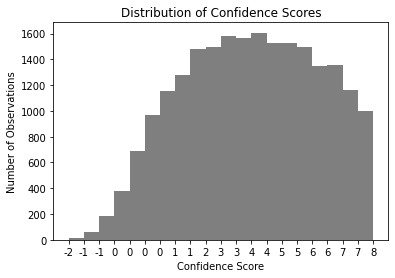

In [ ]:
for num_iteration in range(2,10):
    model = train_new_model()
    path_m = f'/gdrive/MyDrive/checkpoints/missing_labels/model_it_{num_iteration}.pt'
    torch.save(model.state_dict(), path_m)
    label_and_move_images(model)    
    print(num_iteration, " completed")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker

Epoch 0/9
----------


100%|██████████| 1499/1499 [03:21<00:00,  7.42it/s]


Loss: 2.8150 Acc: 0.2674

Epoch 1/9
----------


100%|██████████| 1499/1499 [03:19<00:00,  7.52it/s]


Loss: 1.8394 Acc: 0.3972

Epoch 2/9
----------


100%|██████████| 1499/1499 [03:18<00:00,  7.55it/s]


Loss: 1.4894 Acc: 0.4638

Epoch 3/9
----------


100%|██████████| 1499/1499 [03:20<00:00,  7.49it/s]


Loss: 1.2566 Acc: 0.5212

Epoch 4/9
----------


100%|██████████| 1499/1499 [03:18<00:00,  7.54it/s]


Loss: 1.0734 Acc: 0.5779

Epoch 5/9
----------


100%|██████████| 1499/1499 [03:19<00:00,  7.50it/s]


Loss: 0.9229 Acc: 0.6267

Epoch 6/9
----------


100%|██████████| 1499/1499 [03:18<00:00,  7.56it/s]


Loss: 0.7938 Acc: 0.6839

Epoch 7/9
----------


100%|██████████| 1499/1499 [03:19<00:00,  7.50it/s]


Loss: 0.5339 Acc: 0.8169

Epoch 8/9
----------


100%|██████████| 1499/1499 [03:18<00:00,  7.54it/s]


Loss: 0.4656 Acc: 0.8512

Epoch 9/9
----------


100%|██████████| 1499/1499 [03:18<00:00,  7.55it/s]


Loss: 0.4269 Acc: 0.8710

Training complete in 33m 14s
Best val Acc: 0.871003


 79%|███████▉  | 2061/2617 [00:00<00:00, 11304.16it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


11  completed
Epoch 0/9
----------


100%|██████████| 1563/1563 [03:27<00:00,  7.54it/s]


Loss: 2.8613 Acc: 0.2604

Epoch 1/9
----------


100%|██████████| 1563/1563 [03:26<00:00,  7.56it/s]


Loss: 1.8961 Acc: 0.3888

Epoch 2/9
----------


100%|██████████| 1563/1563 [03:26<00:00,  7.56it/s]


Loss: 1.5528 Acc: 0.4516

Epoch 3/9
----------


100%|██████████| 1563/1563 [03:27<00:00,  7.55it/s]


Loss: 1.3079 Acc: 0.5101

Epoch 4/9
----------


100%|██████████| 1563/1563 [03:27<00:00,  7.54it/s]


Loss: 1.1136 Acc: 0.5699

Epoch 5/9
----------


100%|██████████| 1563/1563 [03:27<00:00,  7.54it/s]


Loss: 0.9555 Acc: 0.6221

Epoch 6/9
----------


100%|██████████| 1563/1563 [03:29<00:00,  7.46it/s]


Loss: 0.8283 Acc: 0.6692

Epoch 7/9
----------


100%|██████████| 1563/1563 [03:29<00:00,  7.46it/s]


Loss: 0.5589 Acc: 0.8065

Epoch 8/9
----------


100%|██████████| 1563/1563 [03:28<00:00,  7.51it/s]


Loss: 0.4854 Acc: 0.8417

Epoch 9/9
----------


100%|██████████| 1563/1563 [03:27<00:00,  7.53it/s]


Loss: 0.4461 Acc: 0.8634

Training complete in 34m 37s
Best val Acc: 0.863400


FileNotFoundError: ignored

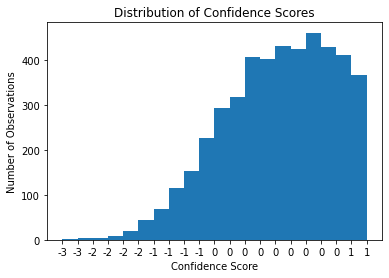

In [ ]:
num_iteration = 10
model = train_new_model() 
path_m = f'/gdrive/MyDrive/checkpoints/missing_labels/model_it_{num_iteration}.pt'
label_and_move_images(model)    
print(num_iteration, " completed")

for num_iteration in range(11,15):
    destination_dir = 'data/task1/train_data/images/unlabeled/0'
    if len(os.listdir(destination_dir)) == 0:
        break
    model = train_new_model() 
    # it may be tempting to train longer, but this may create bias due to 
    # using wrong labels that we have previously generated.
    path_m = f'/gdrive/MyDrive/checkpoints/missing_labels/model_it_{num_iteration}.pt'
    torch.save(model.state_dict(), path_m)
    label_and_move_images(model)    
    print(num_iteration, " completed")

 96%|█████████▌| 2517/2617 [00:00<00:00, 11057.39it/s]


10  completed


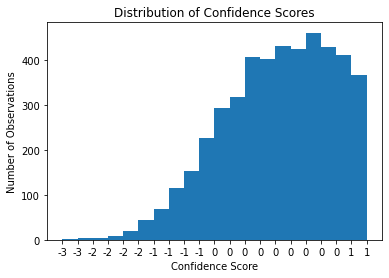

In [ ]:
label_and_move_images(model)    
print(num_iteration, " completed")

In [ ]:
destination_dir = 'data/task1/train_data/images/unlabeled/0'
len(os.listdir(destination_dir))

0

 18%|█▊        | 4578/25517 [00:47<03:37, 96.17it/s]


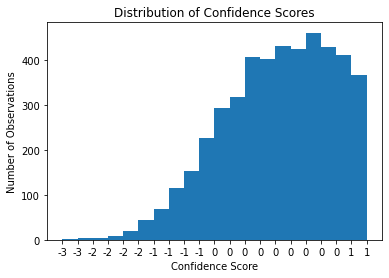

In [ ]:
args = get_unlabled_dataset()
predicted_labels = predict_new_labels(model, *args)
counts, bins, patches = plot_distribution()

In [ ]:
for index, row in tqdm(df_labeled.iterrows(),total=n_keep):
    parts = row['path'].split(".")
    parts[0]+=f"_it_{num_iteration}"
    new_name = ".".join(parts).split('/')[-1]
    dest_path = f"data/task1/labeled/{row['label']}/{new_name}"
    print(dest_path)
    break
    shutil.move(row['path'], dest_path)

  0%|          | 0/2617 [00:00<?, ?it/s]

data/task1/labeled/1/10008_it_2.jpeg


In [ ]:
def undo_changes(num_iteration):
    d_dir = "data/task1/labeled/"
    for d in os.listdir(d_dir):
        for i in os.listdir(d_dir+"/"+d):
            if f"_it_{num_iteration}" in i:
                new_name = i.split(".")
                old_name = new_name[0][:-5]+"."+new_name[1]
                shutil.move(f"{d_dir}/{d}/{i}", f"data/task1/train_data/images/unlabeled/0/{old_name}")
            

In [ ]:
# k-fold cross-validation,  
# or importance sampling

## Predicting for evaluation

In [ ]:
# TODO: prepare dataset for evaluation
# TODO: load model for evaluation
# TODO: check out the labeling requirements for evaluaiton.

# Exploring other solutions

## Clustering the images 
Using a DNN for feature extraction, than clustering the images on those features. 

In [2]:
import urllib
import shutil
import os
import time
import copy
import json

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader
from torchvision import transforms, datasets 

from sklearn.metrics import classification_report

import itertools

In [3]:
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# remove the last fully connected layer ( this is the classification layer)

model = torch.nn.Sequential(*list(model.children())[:-1])

# Freeze the model so the pre-trained weights are not updated during training
for param in model.parameters():
    param.requiresGrad = False

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Extracting features from labeled data

In [4]:
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
# Load the experiment information from the JSON file
with open('experiment_info.json', 'r') as f:
    experiment_info = json.load(f)

In [6]:
preprocess = transforms.Compose([
    transforms.Resize(experiment_info["image_processing"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=experiment_info["image_processing"]["mean"],
                         std=experiment_info["image_processing"]["std"]),
    ])

data_dir = 'data/task1/labeled'
image_dataset = datasets.ImageFolder(data_dir, preprocess) 

dataloader  = DataLoader(
    image_dataset, 
    batch_size = 1,
    shuffle = experiment_info["hyperparameters_data"]["shuffle_dataloader"], 
    num_workers = experiment_info["hyperparameters_data"]["num_workers"]
    )

class_names = image_dataset.classes
dataset_size = len(image_dataset)

In [7]:

img_path_generator_labeled = ((image, path) for (path,_) , (image, label) in zip(image_dataset.samples, dataloader))

features = {"image_id":[], "features":[]}

model = model.to("cuda")

# Iterate over data.
for inputs, image_id in tqdm(img_path_generator_labeled, total = dataset_size):
    inputs = inputs.to("cuda")

    # forward
    with torch.set_grad_enabled(False):
        output = model(inputs)
    features["image_id"].append(image_id)
    features["features"].append(output)
    

100%|██████████| 23555/23555 [04:07<00:00, 95.05it/s]


In [ ]:

img_path_generator_labeled = ((image, path) for (path,_) , (image, label) in zip(image_dataset.samples, dataloader))

features = {"image_id":[], "features":[]}

model = model.to("cuda")

# Iterate over data.
for inputs, image_id in tqdm(img_path_generator_labeled, total = dataset_size):
    inputs = inputs.to("cuda")

    # forward
    with torch.set_grad_enabled(False):
        output = model(inputs)
    # features["image_id"].append(image_id)
    # features["features"].append(output)
    

In [8]:
features["features"] = [f.to('cpu').numpy() for f in features["features"]]

In [28]:
s = features["features"][0].shape
print(f"shape of features {s}")
print("number of pixels in 1 image", 64*64 *3)
print("number of features")
features["features"][0].shape[1] * (features["features"][0].shape[2]**2)

shape of features (1, 1280, 7, 7)
number of pixels in 1 image 12288
number of features


62720

In [32]:
12_000_000 / (62_720*4) # images would fit in memory

47.83163265306123

In [9]:
len(features["features"]) # 23555

23555

In [10]:
labels = []
ids = []
for id in tqdm(features["image_id"]):
    label = id.split(".")[0].split('/')[-2]
    id_image_labeled = id.split(".")[0].split('/')[-1]
    labels.append(int(label))
    ids.append(id_image_labeled)

100%|██████████| 23555/23555 [00:00<00:00, 631955.93it/s]


In [13]:
y_train = np.asarray(labels)
X_train = np.asarray(features["features"])
X_train = X_train.reshape((X_train.shape[0], -1))

In [ ]:
# Create an IPCA object
ipca = IncrementalPCA(n_components=100, batch_size=32)

# Fit the IPCA to your training data
ipca.fit(X_train)

# Use the IPCA to transform the training and test data
X_train_pca = ipca.transform(X_train)
# X_test_pca = ipca.transform(X_test)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_pca,
                                                    np.asarray(labels), 
                                                    test_size=0.2, random_state=42)

# Create the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)
nbrs = NearestNeighbors(n_neighbors=5,
                        algorithm='kd_tree')

nbrs.fit(X_train, y_train)
# Fit the classifier to the training data
# knn.fit(X_train, y_train)


In [ ]:




# Create an instance of the KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
# Train your model on the transformed data
knn.fit(X_train_pca, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Print the accuracy of the classifier
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:

# Extract features from unlabeled data
features_unlabeled = model(X_unlabeled).detach().numpy()

# Predict labels for unlabeled data
predictions = knn.predict(features_unlabeled)

## Extracting features from unlabeled data

In [ ]:
# sanity check to see that all images have been moved to unlabeled/0 dir
assert len(os.listdir(destination_dir)) == 26445, " You need to create the proper unlabeled dataset, like in previous method" # 26445
# set the source and destination directories 
# in the data/task1/train_data/images/unlabeled

In [ ]:
# Create a new dataloader with unlabeled data.
# Dataset folder is a subclass of ImageFolder 
# Which will allow us to return also the path of the image
# because we need it to know which images should be moved 

from torchvision.datasets import DatasetFolder

data_dir = 'data/task1/train_data/images/unlabeled'
image_dataset_unlabeled = datasets.ImageFolder(root=data_dir, transform=preprocess)

dataloader_unlabeled  = torch.utils.data.DataLoader(
    image_dataset_unlabeled, 
    batch_size = 1, 
    )

dataset_size = len(image_dataset_unlabeled)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
features_unlabeled = {"image_id":[], "features":[]}

# Each epoch has a training and validation phase 
model.eval()   # Set model to evaluate mode 

model = model.to(device)
# Iterate over data.
img_path_generator = ((image, path) for (path,_) , (image, _) in zip(image_dataset_unlabeled.samples, dataloader_unlabeled))

for inputs, path in tqdm(img_path_generator, total=len(image_dataset_unlabeled)):
    inputs = inputs.to(device)

    # forward
    with torch.set_grad_enabled(False): # we don't want to train
        outputs = model(inputs) 
    features_unlabeled["image_id"].append(path)
    features_unlabeled["features"].append(output)
    


    

In [ ]:
with open(f'/gdrive/MyDrive/checkpoints/missing_labels/features_unlabeled.json', 'w') as f:
    json.dump(features, f)
 
# Load the experiment information from the JSON file
with open(f'/gdrive/MyDrive/checkpoints/missing_labels/features_unlabeled.json', 'r') as f:
    features = json.load(f)

In [50]:
for i, id in enumerate(features_unlabeled["image_id"]):
    label = id.split(".")[0].split('/')[-2]
    id_image_labeled = id.split(".")[0].split('/')[-1]
    # TODO: add 200000 to the images that are unlabeled 
    # such that I don't get duplicated labels
    print(label, id_image_labeled)
    print(id)
    if i == 3:
        break

0 0
data/task1/train_data/images/unlabeled/0/0.jpeg
0 1
data/task1/train_data/images/unlabeled/0/1.jpeg
0 10
data/task1/train_data/images/unlabeled/0/10.jpeg
0 100
data/task1/train_data/images/unlabeled/0/100.jpeg


# Self-ensembling 
Based on the models we have created previously, we will create an ensemble of models. And we will take the outputs of all the previous models as features for another model of a few fully connected layers. 

The reasoning behind this approach is that ensembling the models may eliminate the biases between them. And give us a higher accuracy.

## Test the model on the new dataset 

In [ ]:
# In order to test if the 2 models are better, we cannot just use the labels we have predicted
# we need to either choose the validation set from the labels we already know are true
# or we could use another dataset only for testing to compare that self-training is better 
# than just training on a smaller dataset with all labels given.

In [ ]:

# This will shuffle the images in the dataset 
# before they are returned to the data loader,
# which should help ensure that the validation and training sets
# are more balanced.
class ShuffledImageFolder(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = torch.randperm(len(dataset))

    def __getitem__(self, index):
        return self.dataset[self.indices[index]]

    def __len__(self):
        return len(self.dataset)

data_dir = 'data/task1/labeled'
image_dataset_unshuffled = datasets.ImageFolder(data_dir, preprocess)
image_dataset = ShuffledImageFolder(image_dataset_unshuffled)

# print(image_datasets)
# We don't want to create a single dataset because we want to have a dataset for evaluation also
# dataloader  = torch.utils.data.DataLoader(image_dataset, batch_size = 4, shuffle = True, num_workers = 4)

# split data into train and val

dataset_size = len(image_dataset)
print(dataset_size)
split = int(dataset_size*0.8)
train_size = split
print(train_size)
val_size = dataset_size - split
print(val_size)
assert val_size+train_size == dataset_size
class_names = image_dataset.dataset.classes

# Create a sampler for the training set
train_sampler = SubsetRandomSampler(range(split))

# Create a sampler for the valuation set
val_sampler = SubsetRandomSampler(range(split, dataset_size))

# Create DataLoaders for the training and valuation sets
train_dataloader = DataLoader(image_dataset, batch_size=32, sampler=train_sampler)
val_dataloader = DataLoader(image_dataset, batch_size=32, sampler=val_sampler, shuffle=False)
dataloaders = {
    "train":train_dataloader,
    "val":val_dataloader,
}
dataset_sizes = {
    "train":train_size,
    "val":val_size,
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Setting hyperparameters

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)